In [ ]:
## 1
library(tidyr)
library(dplyr)
library(limma)
library(clusterProfiler)
library(org.Hs.eg.db)

In [3]:
protein=read.delim("20240624_145736_2024-WZ-WQ-310samples-proteome_Report_proteins.tsv", header = TRUE, sep = "\t")

In [ ]:
protein <- as.data.frame(protein)
selected_columns <- protein %>%
  dplyr::select(PG.ProteinAccessions, contains(".PG.Quantity"))

In [ ]:
ID=read.table("256sample_mutation_paired_clinical_filter_adjust.csv", header = TRUE, sep = ",", quote="\"")
protein<- unique(read.table("protein_expression.csv", sep = ",", header=T,quote="\"",na.strings = "NaN",check.names = FALSE))
protein_ID=read.table("proteinID_ID.csv", header = TRUE, sep = ",", quote="")

In [13]:
selected_ID=unique(merge(ID[,1],protein_ID,by.x=1,by.y=2))

In [15]:
selected_columns<- c(1,which(colnames(protein) %in% selected_ID$Protein.ID))

In [17]:
protein_data=protein[,selected_columns]

In [ ]:
df_separated <- protein_data %>%
  distinct(PG.ProteinAccessions, .keep_all = TRUE) %>%
  separate_rows(PG.ProteinAccessions, sep = ";")

In [22]:
gene_symbols <- bitr(df_separated$PG.ProteinAccessions, fromType = "UNIPROT", 
                     toType = "SYMBOL", 
                     OrgDb = org.Hs.eg.db)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(df_separated$PG.ProteinAccessions, fromType = "UNIPROT", :
“5.59% of input gene IDs are fail to map...”


In [24]:
protein_all=merge(df_separated,gene_symbols,by.x=1,by.y=1)

In [25]:
protein_all=protein_all[,c(225,2:224)]

In [ ]:

protein_all_numeric <- protein_all %>%
  mutate(across(-SYMBOL, ~ as.numeric(as.character(.))))

df_mean <- protein_all_numeric %>%
  group_by(SYMBOL) %>%
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE), .names = "mean_{col}"), .groups = 'drop')

Warning message:
“There were 223 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(-SYMBOL, ~as.numeric(as.character(.)))`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 222 remaining warnings.”


In [31]:
df_mean=as.data.frame(df_mean)

In [ ]:
first_column <- df_mean[, 1]

rownames(df_mean) <- first_column

df_mean_new <- df_mean[, -1]

In [ ]:

expression_numeric <- as.matrix(df_mean_new)
qn_matrix <- normalizeBetweenArrays(expression_numeric, method = "quantile")
dimnames(qn_matrix) <- dimnames(df_mean_new)

In [37]:
filtered_qn_matrix <- qn_matrix[rownames(qn_matrix) %in% gene, ]

In [ ]:
final_phospho=t(filtered_qn_matrix)
final_phospho <- cbind(Protein = rownames(final_phospho), final_phospho)
rownames(final_phospho) <- NULL

In [40]:
final_phospho=as.data.frame(final_phospho)

In [ ]:

final_phospho$Protein <- gsub("^mean_", "", final_phospho$Protein)

In [42]:
final_phospho_class=merge(final_phospho,protein_ID,by.x=1,by.y=1)
final_phospho_class=final_phospho_class[,c(1,13,14,2:12)]

In [44]:
filtered_data <- final_phospho_class %>%
  group_by(ID) %>%
  filter(any(class == "adjacent") & any(class == "tumor")) %>%
  ungroup() %>%
  arrange(ID)

In [48]:
tumor_data <- final_phospho_class %>%
  filter(class == "tumor")

In [ ]:
final_phospho_long <- final_phospho_class %>%
  pivot_longer(cols = c(ATP6,ATP8,COX1,COX2,COX3,CYTB,ND1,ND3,ND4,ND5,ND6),  
               names_to = "Gene",        
               values_to = "Expression")

Warning message:
“Removed 210 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 210 rows containing missing values or values outside the scale range
(`geom_point()`).”


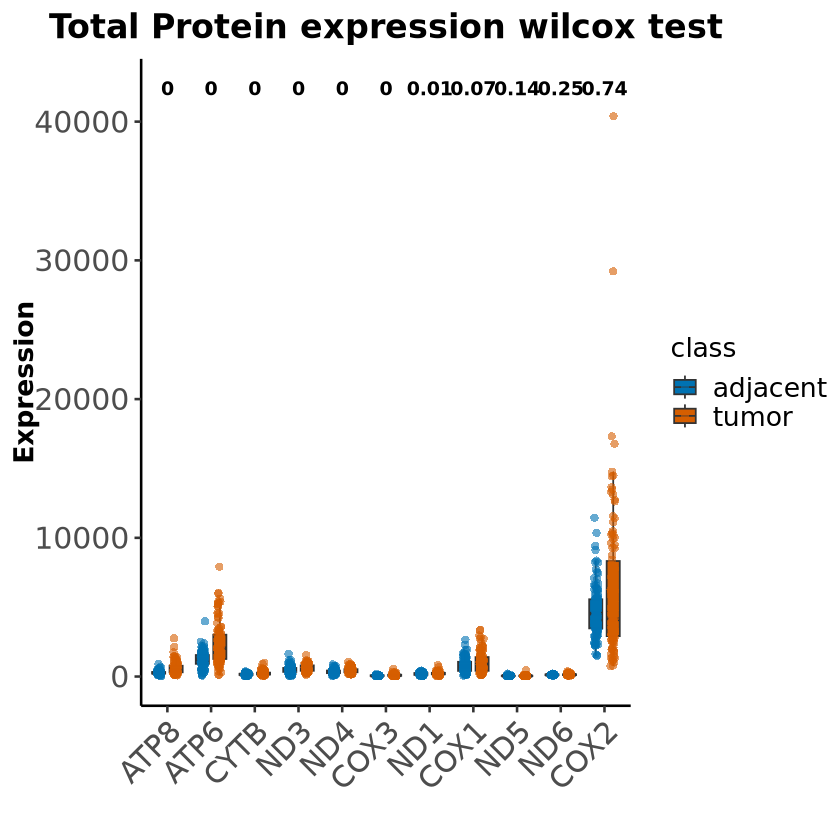

In [ ]:
library(ggplot2)
library(ggpubr)
library(dplyr)

custom_colors <- c("adjacent" = "#0072B2", "tumor" = "#D55E00")
final_phospho_long$class <- as.factor(final_phospho_long$class)
final_phospho_long$Expression <- as.numeric(as.character(final_phospho_long$Expression))

p_value <- final_phospho_long %>%
  filter(class %in% c("adjacent", "tumor")) %>%
  group_by(Gene) %>%
  summarise(
    p_value = tryCatch(
      wilcox.test(Expression ~ class, exact = FALSE)$p.value,
      error = function(e) NA
    ),
    .groups = 'drop'
  ) %>%
  arrange(p_value)

final_phospho_long$Gene <- factor(final_phospho_long$Gene, levels = p_value$Gene)

p_value_labels <- paste0("", round(p_value$p_value, 2))

p <- ggplot(final_phospho_long, aes(x = Gene, y = Expression, fill = class)) +
  geom_boxplot(outlier.shape = NA, width = 0.6, position = position_dodge(0.8)) +
  geom_jitter(aes(color = class), size = 2, alpha = 0.6, shape = 16,
              position = position_jitterdodge(jitter.width = 0.2)) +
  scale_fill_manual(values = custom_colors) +
  scale_color_manual(values = custom_colors) +
  theme_classic(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 18),
    axis.text.y = element_text(size = 18),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16, face = "bold"),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 16),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20)
  ) +
  labs(title = "Total Protein expression wilcox test",
       x = "",
       y = "Expression")
for (i in 1:nrow(p_value)) {
  p <- p + annotate("text", 
                    x = i, 
                    y = max(final_phospho_long$Expression, na.rm = TRUE) * 1.05, 
                    label = p_value_labels[i], 
                    size = 4, fontface = "bold", hjust = 0.5)
}

print(p)

In [ ]:
## 2

In [ ]:
library(tidyr)
library(dplyr)
library(limma)

In [ ]:
ID=read.table("256sample_mutation_paired_clinical_filter_adjust.csv", header = TRUE, sep = ",", quote="\"")
phospho<- unique(read.table("Phospho protein expression.csv", sep = ",", header=T,quote="\"",na.strings = "NaN",check.names = FALSE))
protein_ID=read.table("proteinID_ID.csv", header = TRUE, sep = ",", quote="")

In [ ]:
gene=unique(ID$Gene.MT_ensGene)

In [ ]:
selected_ID=unique(merge(ID[,1],protein_ID,by.x=1,by.y=2))

In [ ]:
selected_columns<- c(1,which(colnames(phospho) %in% selected_ID$Protein.ID))

In [ ]:
phospho_data=phospho[,selected_columns]

In [ ]:
df_separated <- phospho_data %>%
  distinct(protein, .keep_all = TRUE) %>%
  separate_rows(protein, sep = ";")

In [ ]:
df_mean <- df_separated %>%
  group_by(protein) %>%
  summarise(across(everything(), mean))

In [ ]:
df_mean=as.data.frame(df_mean)

In [ ]:
first_column <- df_mean[, 1]

rownames(df_mean) <- first_column

df_mean_new <- df_mean[, -1]

In [ ]:
expression_numeric <- as.matrix(df_mean_new)
qn_matrix <- normalizeBetweenArrays(expression_numeric, method = "quantile")
dimnames(qn_matrix) <- dimnames(df_mean_new)

In [ ]:
filtered_qn_matrix <- qn_matrix[rownames(qn_matrix) %in% gene, ]

In [ ]:
final_phospho=t(filtered_qn_matrix)
final_phospho <- cbind(Protein = rownames(final_phospho), final_phospho)

rownames(final_phospho) <- NULL

In [ ]:
final_phospho_class=merge(final_phospho,protein_ID,by.x=1,by.y=1)
final_phospho_class=final_phospho_class[,c(1,5,6,2:4)]

In [ ]:
filtered_data <- final_phospho_class %>%
  group_by(ID) %>%
  filter(any(class == "adjacent") & any(class == "tumor")) %>%
  ungroup() %>%
  arrange(ID)

In [ ]:
tumor_data <- final_phospho_class %>%
  filter(class == "tumor")

In [ ]:
final_phospho_long <- final_phospho_class %>%
  pivot_longer(cols = c(COX2, COX3, CYTB), 
               names_to = "Gene",       
               values_to = "Expression")

In [ ]:
library(ggplot2)
library(ggpubr)
library(dplyr)

custom_colors <- c("adjacent" = "#0072B2", "tumor" = "#D55E00")
final_phospho_long$class <- as.factor(final_phospho_long$class)

final_phospho_long$Expression <- as.numeric(as.character(final_phospho_long$Expression))

p_value <- final_phospho_long %>%
  filter(class %in% c("adjacent", "tumor")) %>%
  group_by(Gene) %>%
  summarise(
    p_value = tryCatch(
      wilcox.test(Expression ~ class, exact = FALSE)$p.value,
      error = function(e) NA
    ),
    .groups = 'drop'
  ) %>%
  arrange(p_value)

final_phospho_long$Gene <- factor(final_phospho_long$Gene, levels = p_value$Gene)

p_value_labels <- paste0("", round(p_value$p_value, 2))

p <- ggplot(final_phospho_long, aes(x = Gene, y = Expression, fill = class)) +
  geom_boxplot(outlier.shape = NA, width = 0.6, position = position_dodge(0.8)) +
  geom_jitter(aes(color = class), size = 2, alpha = 0.6, shape = 16,
              position = position_jitterdodge(jitter.width = 0.2)) +
  scale_fill_manual(values = custom_colors) +
  scale_color_manual(values = custom_colors) +
  theme_classic(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 18),
    axis.text.y = element_text(size = 18),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16, face = "bold"),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 16),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20)
  ) +
  labs(title = "Phospho expression wilcox test",
       x = "",
       y = "Expression")

for (i in 1:nrow(p_value)) {
  p <- p + annotate("text", 
                    x = i, 
                    y = max(final_phospho_long$Expression, na.rm = TRUE) * 1.05, 
                    label = p_value_labels[i], 
                    size = 4, fontface = "bold", hjust = 0.5)
}

print(p)